# Building Deep Neural Network Step by Step Using Cat vs non Cat Dataset

We will build a deep neural network with many layers as we want.

- In this notebook, we will implement all the functions required to build a deep neural network.
- After that, we will use these functions to build a deep neural network for image classification.


# 1 - Packages
Let's first import all the packages that we need for our task. 

- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- np.random.seed(1) is used to keep all the random function calls consistent.

In [30]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2- Overview of the Dataset

The dataset we used in this task is taken from Andrew Ng’s course on Coursera Introduction to Neural Networks.<br>
The dataset (“data.h5”) contains:

- 209 training examples
- 50 test examples
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px)   and (width = num_px).

In order to interact with the cat vs non cat dataset lets build a load_data() helper function. it will load the training and test images along with their classes from h5py data file.

In [31]:
def load_data():
    train_dataset = h5py.File('C:/Users/Ehsan Ullah/Desktop/L_Layered_Neural_Network/ImageDataset/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('C:/Users/Ehsan Ullah/Desktop/L_Layered_Neural_Network/ImageDataset/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


Let's load the dataset by calling the load_data() function

In [32]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()


Let’s get more familiar with the dataset. The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images.

y = 0. It's a non-cat picture.


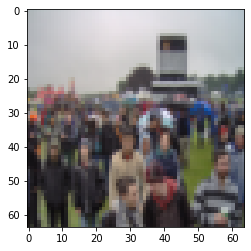

In [33]:
#Example of a non-cat picture
index = 100
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

y = 1. It's a cat picture.


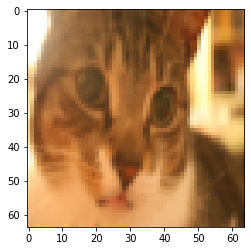

In [34]:
# Example of a cat picture
index = 200
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

# 3- Data Preprocessing
Common steps for pre-processing a new dataset are:

- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, …)
- Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
- “Standardise” the data

Let's explore the size an dimensions as well as the number of training and test examples in the dataset using the code below

In [35]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


For convenience, we now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px * num_px * 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. <br> 
The reason for this is we are not using convoloutional layer instead we are directly passing the vector array of image sizes directly into the connected layers of our Neural Network.<br>
One common preprocessing step in machine learning and deep learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).<br>


In [36]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


<img src="Desktop/L_Layered_Neural_Network/Images/Reshape.jpg" style="width:650px;height:370px;"/>

# L-Layer Neural Network Architecture
Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.<br>
Let's look at the architecture.

<img src="Desktop/L_Layered_Neural_Network/Images/L-Layered.png" style="width:800px;height:500px;"/>

- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then we add   the intercept $b^{[1]}$. The result is called the linear unit.
- Next, we take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$  depending on the model architecture.
- The process is repeated for each hidden layer and several times (number of iterations), each time calculating the  loss     and back-propagating appropriate changes in the weights until the wished loss is reached.
- Finally, we take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

#  Outline of the Task/General Methodology

We will be implementing several "helper functions". These helper functions will help us to build an L-layer neural network. Each small helper function we will implement will have detailed instructions that will walk you through the necessary steps. Here is an outline of the task:

- Initialize the parameters for an $L$-layer neural network.
- Implement the forward propagation module (shown in purple in the figure below).
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$).
     - Using ACTIVATION functions (relu/sigmoid).
     - Combining the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stacking the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives us a new L_model_forward function.
- Computing the loss.
- Implementing backward propagation module (denoted in red in the figure below).
    - Completing the LINEAR part of a layer's backward propagation step.
    - using gradients of the ACTIVATION functions (relu_backward/sigmoid_backward) 
    - Combining the previous two steps into a new [LINEAR->ACTIVATION] backward function.
    - Stacking [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally updating the parameters.
- Use trained parameters to predict labels

<img src="Desktop/L_Layered_Neural_Network/Images/GeneralStructure.png" style="width:650px;height:400px;"/>



**Note** that for every forward function, there is a corresponding backward function. That is why at every step of your forward module you will be storing some values in a cache. The cached values are useful for computing gradients. In the backpropagation module you will then use the cache to calculate the gradients. This assignment will show you exactly how to carry out each of these steps. 


# 4 – Initializing parameters

There are two types of parameters to initialize in a neural network:
- the weight matrices $W^{[i]}$
- the bias vectors $b^{[i]}$

The weight matrix is initialized with random values while the bias vector as a vector of zeros.
In general, initializing all the weights to zero results in the network failing to break symmetry. This means that every neuron in each layer will learn the same thing and the network is no more powerful than a linear classifier such as logistic regression.

To break symmetry, we initialize the weights randomly. Following random initialization, each neuron can then proceed to learn a different function of its inputs.
Of course, different initializations lead to different results and poor initialization can slow down the optimisation algorithm.


## 4.1 – Initialization of L-layer Neural Network
The initialization for an L-layer neural network is complicated because there are many weight matrices and bias vectors. Need to make sure that the dimensions match between each layer. Recall that $n^{[l]}$ is the number of units in layer $l$. Thus for example if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:


<table style="width:100%">


   <tr>
        <td>  </td> 
    <td> <b>Shape of W </b></td> 
    <td> <b>Shape of b</b>  </td> 
    <td> <b>Activation</b> </td>
        <td> <b>Shape of Activation</b></td> 
    <tr>
    
   <tr>
    <td> <b>Layer 1</b> </td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},209)$ </td> 
   <tr>
    
   <tr>
    <td> <b>Layer 2</b> </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
   
   <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>
    
   <tr>
    <td> <b>Layer L-1</b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
    <tr>
    
    
   <tr>
    <td> <b>Layer L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>

</table>

**Note**
- The model's structure is $[LINEAR -> RELU]  \times (L-1) -> LINEAR -> SIGMOID$. I.e., it has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.
- using random initialization for the weight matrices. we will use np.random.randn(shape) * 0.01.
- zeros initialization for the biases by using np.zeros(shape).
- We will store $n^{[l]}$, the number of units in different layers, in a variable `layer_dims`. For example, a model with two inputs, one hidden layer with 4 hidden units and an output layer with 1 output unit would have dimensions equal to [2,4,1]. Thus means `W1`’s shape is (4,2), `b1` is (4,1), `W2` is (1,4) and `b2` is (1,1).

In [37]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [38]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]
b2 = [[0.]
 [0.]
 [0.]]


# 5- Forward propagation module
Now that we have initialized our parameters, we will do the forward propagation module.

We will implement some helper functions and then put all together:

- linear_forward: implement the linear part, i.e. the $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$ equation, where $A^{[0]} = X.$
- linear_activation_forward: will add to the linear part the activation where activation will be either ReLU or Sigmoid.
- L-model_forward: will call the $[LINEAR -> RELU] \times (L-1)$ times, finally the LINEAR -> SIGMOID

<img src="Desktop/L_Layered_Neural_Network/Images/Forward.png"/>

## 4.1 – Linear Forward

In [39]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.
    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

## 5.2 – Linear-Activation Forward

We will use two activation functions:

- Sigmoid: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$.
This function returns two items: the activation value “a” and a “cache” that contains “Z” (it’s what we will feed in to the corresponding backward function).
To use it you could just call:<br>
**A, activation_cache = sigmoid(Z)**

- ReLU: The mathematical formula for ReLu is A = RELU(Z) = max(0, Z).
This function returns two items: the activation value “A” and a “cache” that contains “Z” (it’s what we will feed in to the corresponding backward function).
To use it you could just call:<br>
**A, activation_cache = relu(Z)**

For more convenience, we are going to group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION). Hence, we will implement a function that does the LINEAR forward step followed by an ACTIVATION forward step.


Next: Implement the forward propagation of the LINEAR->ACTIVATION layer.<br>
Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation “g” can be sigmoid() or relu()

In [40]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

### Sigmoid Activation Fucntion

In [41]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

### Relu Activation Function

In [42]:
def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

## 5.3 L-Layered Forward Propagation
For even more convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.
<br><br>
In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 


- Using the functions we had previously written 
- Use a for loop to replicate [LINEAR->RELU] (L-1) times
- Don't forget to keep track of the caches in the "caches" list. To add a new value `c` to a `list`, we can use `list.append(c)`.

In [43]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches


Great! Now we have a full forward propagation that takes the input X and outputs a row vector $A^{[L]}$ containing our predictions.<br> It also records all intermediate values in “caches”. Using $A^{[L]}$, we can compute the cost of our predictions.

# 6- Cost function
Now we need to compute the cost, because we want to check if our model is actually learning.<br>

Next: Compute the cross-entropy cost J, using the following formula:
$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) $

In [44]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost


# 7- Backward propagation module

<br>Now we will implement the backward function for the whole network.<br>

<img src="/Ehsan-Khan/L_Layered_Neural_Network/blob/master/Images/Backward.png" />

Just like with forward propagation, we will implement helper functions for backpropagation.<br> Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters.<br><br>
Now, similar to forward propagation, we are going to build the backward propagation in three steps:
- linear backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- $[LINEAR -> RELU] \times (L-1) -> LINEAR -> SIGMOID$ backward (whole model)

Reminder:
<img src="Desktop/L_Layered_Neural_Network/Images/ForBac.png"/>

## 7.1 – Linear backward
For layer l, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Now we need to compute the three derivatives $(dW^{[l]}, db^{[l]}, dA^{[l]})$, using as input a known derivate $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. :

- $dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$ 
- $db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$
- $dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$ 

In [45]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)
    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

## 7.2 – Linear-Activation backward
Next, we will create a function that merges the two helper functions: `linear_backward` and the backward step for the activation:

- `sigmoid_backward`: Implements the backward propagation for SIGMOID unit.

- `relu_backward`: Implements the backward propagation for RELU unit.

If g(.) is the activation function, `sigmoid_backward` and `relu_backward` compute $dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$ .

In [46]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

## Sigmoid Backward

In [47]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


## Relu Backward

In [48]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ



## 7.3 – L-Model Backward
Recall that when we implemented the `L_model_forward` function, at each iteration, we stored a cache which contains (X,W,b, and z).<br> In the back propagation module, we will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, we will iterate through all the hidden layers backward, starting from layer L. On each step, we will use the cached values for layer l to back-propagate through layer l.

<img src="Desktop/L_Layered_Neural_Network/Images/Lbackward.png"/>


**Initializing backpropagation**:
To backpropagate through this network, we know that the output is, 
$A^{[L]} = \sigma(Z^{[L]})$. So we need to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula (derived using calculus which you don't need in-depth knowledge of):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

We can then use this post-activation gradient `dAL` to keep going backward. We can now feed in `dAL` into the LINEAR->SIGMOID backward function we implemented (which will use the cached values stored by the L_model_forward function). After that, We will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. We should store each dA, dW, and db in the grads dictionary. To do so,  we will use this formula : 

$$grads["dW" + str(l)] = dW^{[l]} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.

In [49]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,
                                                                                                  activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


# 8- Update Parameters
In this section we will update the parameters of the model, using gradient descent:

- $W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$ 
- $b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$ 

where $\alpha$ is the learning rate. After computing the updated parameters, we store them in the parameters dictionary.

In [50]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

# 9  L-Layered Neural Network

Using the helper functions we have implemented above to build an $L$-layer neural network with the following structure:<br> [LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID. The functions we need and their inputs are:

```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [51]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

In [52]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
          
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


We will now train the model as a 5-layer neural network. 

Let's run the cell below to train your model. The cost should decrease on every iteration. It may take up some time to run 3000 iterations.

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878
Cost after iteration 2500: 0.088413
Cost after iteration 2600: 0.085951
Cost after iteration 2700: 0.081681
Cost

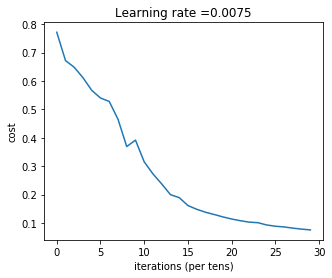

In [53]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations=3000, print_cost=True)


# 11- Results analysis
Now we can check the performance of the trained network by predicting the results of the test set and comparing them with the actual labels.

In [54]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [55]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9904306220095691


In [56]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8200000000000001


This is good performance for this task.

Even higher accuracy could be obtained, by systematically searching for better hyperparameters (learning_rate, layers_dims, num_iterations) and other techniques such as regularisation

# 11- Mislabeled Images

Lastly, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

In [57]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))



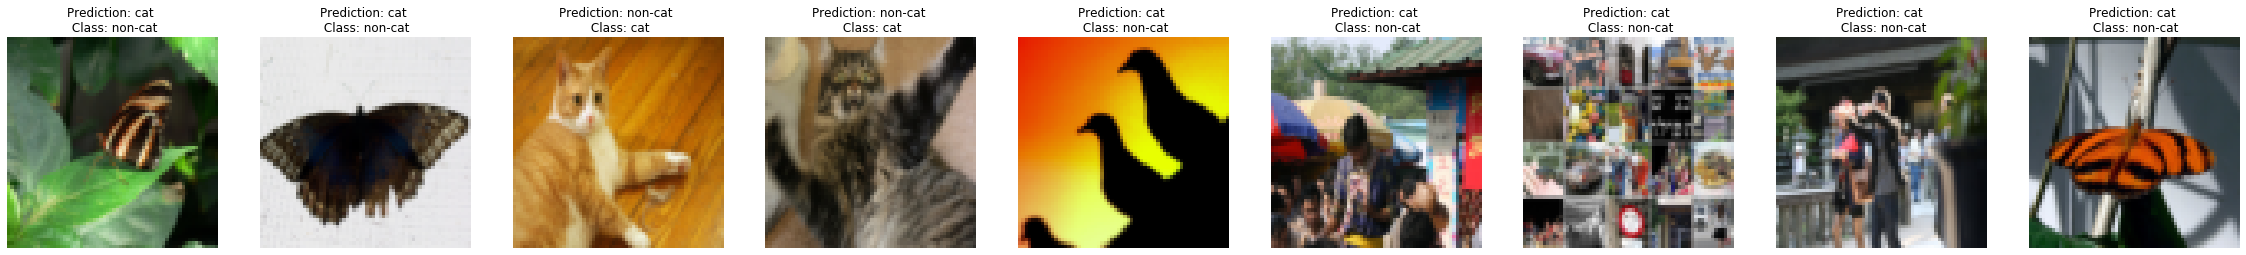

In [58]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few type of images the model tends to do poorly on include:**

- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image)

**Bibliography:<br>
[Andrew Ng's Deep Learning Course](https://www.deeplearning.ai/)<br>
[Deep Learning Activations Analyticsvidhya](https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/)<br>
[Deep Learning Activations](https://towardsdatascience.com/comparison-of-activation-functions-for-deep-neural-networks-706ac4284c8a)<br>
[Derivatives of common activation functions](https://theclevermachine.wordpress.com/2014/09/08/derivation-derivatives-for-common-neural-network-activation-functions/)**